In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Analysis
Once the data is clean and ready, we should:
- select appropriate methods
- select appropriate parameters for them
- set up grid search and crossvalidation
- run the analysis

In [2]:
X = np.load("X.npy")
y = np.load("y.npy")

## Selection of methods
In general, before applying large and expensive models, it is good to try simple linear models. More than one model should be used :)

In this case, we are performing multiclass classification. 

Nested crossvalidation:

▶ Use an outer loop for model selection and an inner loop for
hyperparameter tuning

▶ This is the most computationally expensive but also the most
reliable method

▶ Outer loop: split the data into 𝑘 folds, train on 𝑘 − 1 folds and
test on the remaining fold

▶ Inner loop: for each fold, perform hyperparameter tuning using
crossvalidation on the training set

In [3]:
inner_cv = KFold(n_splits = 3, shuffle=True)
outer_cv = KFold(n_splits = 10, shuffle=True)

## 📌 KNN

**Hyperparameter**:
- Anzahl betrachteter Nachbarn (`n_neighbors`)
- Gewichtung der Nachbarn (`weights`), z. B. `'uniform'` oder `'distance'`

**Inner CV**:
- Auswahl der besten Hyperparameter für jeden Outer-Fold

**Outer CV**:
- Bewertung der Modellgüte auf unabhängigen Testdaten

---

## 🧪 Nested Cross-Validation

Die **Nested Cross-Validation** berechnet die **Modellgüte** unter realistischen Bedingungen, da sie doppelt verschachtelt ist:

### 🔁 Outer Cross-Validation
- Misst die Modellgüte über mehrere Folds
- Jeder Fold nutzt einen eigenen Testdatensatz
- Für jeden Fold wird ein **Modell mit eigenen, optimierten Hyperparametern** trainiert

### 🔁 Inner Cross-Validation (für jeden Outer-Fold)
- Führt eine **Hyperparameter-Optimierung** durch
- Teilt die Trainingsdaten des aktuellen Outer-Folds erneut in Trainings- und Validierungsdaten
- Führt eine **Grid Search** durch:
  - Testet systematisch alle Hyperparameter-Kombinationen
  - Wählt die beste Kombination basierend auf der durchschnittlichen Leistung

---

## 🛠️ Zusammenfassung

- Die innere CV **optimiert die Hyperparameter**
- Die äußere CV **misst die echte Modellgüte**
- So wird **Überanpassung (Overfitting) bei der Hyperparameterwahl vermieden**
- Besonders nützlich, wenn du Modelle vergleichen willst (z. B. KNN vs. DT vs. RF)

In [9]:
hyperparams_KNN = {
    'n_neighbors' : [2,5,10,25],
    'weights' : ['uniform', 'distance'],
}

grid_KNN = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=hyperparams_KNN,
    scoring="roc_auc_ovr_weighted",
    cv = inner_cv,
)

scores_KNN = cross_validate(grid_KNN, X=X, y=y, cv=outer_cv, scoring="roc_auc_ovr_weighted", return_train_score=True)

## DT

In [16]:
hyperparams_DT = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : [None, 5, 10, 20],
}

grid_DT = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=hyperparams_DT,
    scoring='roc_auc_ovr_weighted',  # Beispiel für mehrklassige AUC
    cv=inner_cv,                     # innere CV (z.B. 3-fach)
)
scores_DT = cross_validate(grid_DT, X=X, y=y, cv=outer_cv, scoring="roc_auc_ovr_weighted", return_train_score=True)

## RF

In [12]:
hyperparams_RF = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 5, 10, 20],
    'n_estimators' : [20,50,100]
}

grid_RF = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=hyperparams_RF,
    scoring='roc_auc_ovr_weighted',  # Beispiel für mehrklassige AUC
    cv=inner_cv,                     # innere CV (z.B. 3-fach)
)
scores_RF = cross_validate(grid_RF, X=X, y=y, cv=outer_cv, scoring="roc_auc_ovr_weighted", return_train_score=True)

## MLP

In [14]:
hyperparams_NN = {
    'hidden_layer_sizes' : [(50,50,), (10,10,), (100,), (100,100)],
    'activation' : ['relu', 'logistic'],
}

grid_NN = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=hyperparams_NN,
    scoring='roc_auc_ovr_weighted',  # Beispiel für mehrklassige AUC
    cv=inner_cv,                     # innere CV (z.B. 3-fach)
)
scores_NN = cross_validate(grid_NN, X=X, y=y, cv=outer_cv, scoring="roc_auc_ovr_weighted", return_train_score=True)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

In [18]:
def cross_val_to_df(scores, model_name):
    df = pd.DataFrame({
        "cv": range(1, len(scores["train_score"]) + 1),  # CV fold index
        "train_auc": scores["train_score"],
        "test_auc": scores["test_score"],
        "fit_time": scores["fit_time"],
        "model": model_name
    })
    return df
print(scores_RF)
# Combine into a single DataFrame
df_all = pd.concat(
    [
        cross_val_to_df(scores_RF, "RF"),
        cross_val_to_df(scores_DT, "DT"),
        cross_val_to_df(scores_KNN, "KNN"),
        cross_val_to_df(scores_NN, "MLP"),        
        ], ignore_index=True)

df_all

{'fit_time': array([4.91366649, 4.78306866, 5.0171876 , 4.81027818, 4.91900468,
       4.70388198, 4.57033229, 4.46580911, 4.61447239, 4.71177649]), 'score_time': array([0.        , 0.        , 0.00639033, 0.00854945, 0.00829053,
       0.0030551 , 0.        , 0.01546049, 0.00131655, 0.        ]), 'test_score': array([1.        , 1.        , 1.        , 0.98380952, 0.93367003,
       1.        , 1.        , 1.        , 0.98690476, 1.        ]), 'train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}


,cv,train_auc,test_auc,fit_time,model
0,1,1.000000,1.000000,4.913666,RF
1,2,1.000000,1.000000,4.783069,RF
2,3,1.000000,1.000000,5.017188,RF
3,4,1.000000,0.983810,4.810278,RF
4,5,1.000000,0.933670,4.919005,RF
5,6,1.000000,1.000000,4.703882,RF
6,7,1.000000,1.000000,4.570332,RF
7,8,1.000000,1.000000,4.465809,RF
8,9,1.000000,0.986905,4.614472,RF
9,10,1.000000,1.000000,4.711776,RF


Use seaborn's `boxplot` to plot the train and test performance, as well as the fit time for each model.

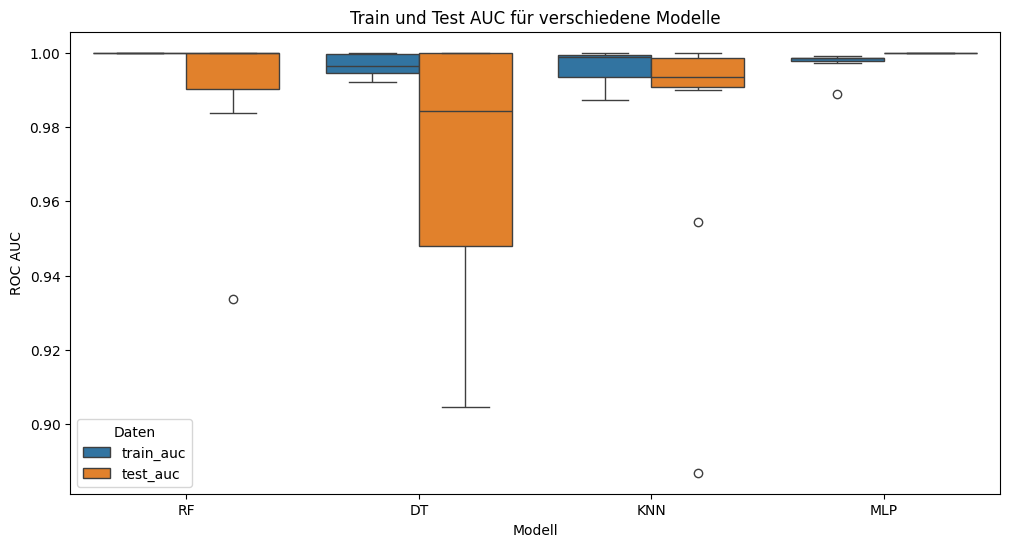

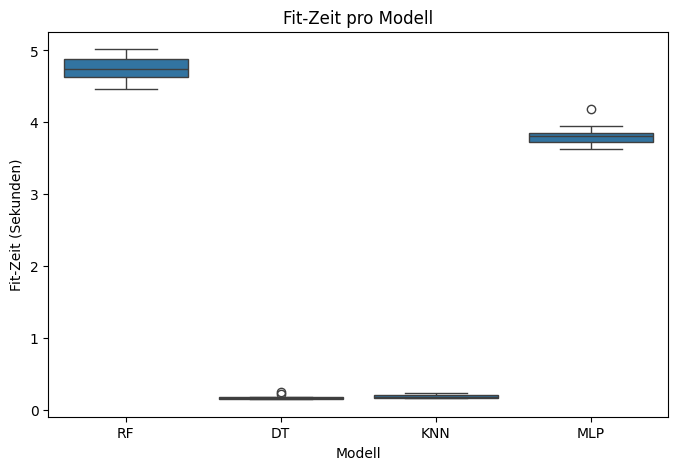

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Trainings- und Test-AUC als Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_all.melt(id_vars=["cv", "model"], value_vars=["train_auc", "test_auc"], var_name="dataset", value_name="AUC"),
    x="model",
    y="AUC",
    hue="dataset"
)
plt.title("Train und Test AUC für verschiedene Modelle")
plt.xlabel("Modell")
plt.ylabel("ROC AUC")
plt.legend(title="Daten")
plt.show()

# 2. Fit-Zeit Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_all,
    x="model",
    y="fit_time"
)
plt.title("Fit-Zeit pro Modell")
plt.xlabel("Modell")
plt.ylabel("Fit-Zeit (Sekunden)")
plt.show()

# Additional considerations
We can then be interested into analysing:
- the feature importance of the best model
- the decision boundary (if applicable)


In this case, note that cross_validate can return one estimator per fold. We can then select them fold by fold and calculate the permutation feature importance.

In [ ]:
scores_KNN = cross_validate(grid_KNN, X=X, y=y, cv=outer_cv, scoring="roc_auc_ovr_weighted", return_train_score=True, return_estimator=True)
#print(scores_KNN["estimator"]) # alle trainierten Modelle für jeden Outer Fold
knn = scores_KNN["estimator"][0] # Modell für ersten Outer Fold
print(knn.best_estimator_) # gibt uns das beste Modell (Wahl der Hyperparameter des ersten Folds zurück)

KNeighborsClassifier(n_neighbors=25, weights='distance')


## Wir schauen uns jetzt für "knn", das Modell des ersten Outer Folds für den KNN Algorithmus die Wichtigkeit der verschiedenen Features an. 

Dafür schauen wir uns die Permutation Performance an. Sie misst, wie wichtig jede Eingabefeature ist, indem sie diese zufällig permutiert (also durchmischt) und schaut, wie stark sich die Modellleistung verschlechtert.

In [27]:
from sklearn.inspection import permutation_importance
imp = permutation_importance(knn, X, y, n_repeats=20)

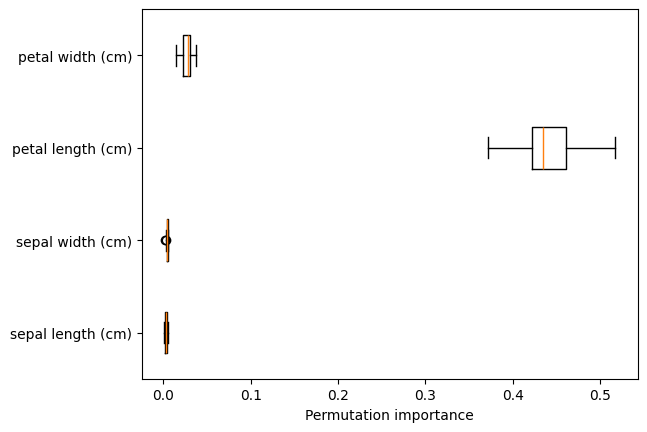

In [28]:
plt.boxplot(imp.importances.T, vert=False)
plt.yticks(range(1,5), ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)'])
plt.xlabel("Permutation importance")
plt.show()